In [1]:
import torch
import foolbox as fb
import timm
from PIL import Image
from urllib.request import urlopen
import requests
import numpy as np
import torchvision as tivision

/home/michaelangelo/Benchmark-of-Methods-for-Adversarial-Attacks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

In [3]:
model = timm.create_model('vgg16.tv_in1k', pretrained=True)
model = model.eval()


In [4]:
img = Image.open(urlopen(
    'https://as2.ftcdn.net/v2/jpg/04/98/82/07/1000_F_498820758_h5nQBIIq4xUdQdfHpUjSLQhyz1UJb16j.jpg'
))

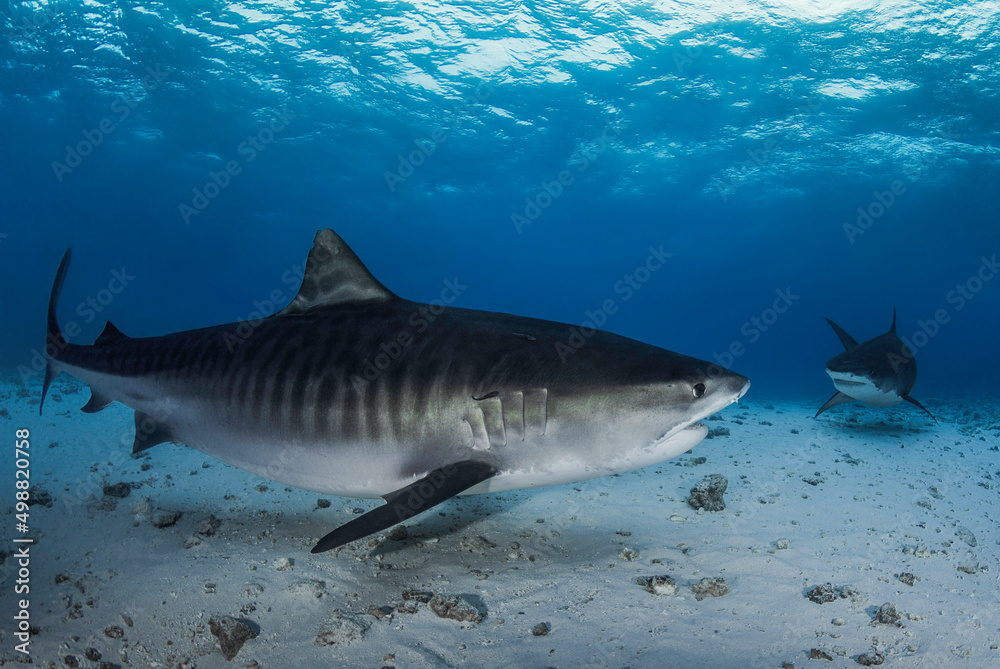

In [5]:
# show image
img.show()


In [6]:
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)
input_tensor = transforms(img).unsqueeze(0)

In [7]:
with torch.no_grad():
    logits = model(input_tensor) 
probabilities = torch.nn.functional.softmax(logits, dim=-1)

In [8]:
print(probabilities.sum())


tensor(1.0000)


NO LABELS PROVIDED! 
However in docs we can see than this model was trained on ImageNet1k.

In [9]:
import requests

In [10]:
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_labels = requests.get(url).json()

In [11]:
display(imagenet_labels)

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead shark',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'American robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'American dipper',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'fire salamander',
 'smooth newt',
 'newt',
 'spotted salamander',
 'axolotl',
 'American bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead sea turtle',
 'leatherback sea turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'green iguana',
 'Carolina anole',
 'desert grassland whiptail lizard',
 'agama',
 'frilled-necked lizard',
 'alligator lizard',
 'Gila monster',
 'European green lizard',
 'chameleon',
 'Komodo dragon',
 'Nile crocodile',
 'American alligator',
 'triceratops',
 'worm snake',
 'ring-necked snake',
 'eastern hog-nosed snake',
 'smooth green snake',
 'kingsnake',
 'garter snake',
 'water snake',
 'vin

In [12]:
predicted_index = torch.argmax(probabilities).item()
predicted_label = imagenet_labels[predicted_index]
print(predicted_label)

tiger shark


In [13]:
def get_label_for_image(image_url: str, model_name: str = 'vgg16.tv_in1k'):
    model = timm.create_model(model_name, pretrained=True)
    model.eval()
    
    img = Image.open(urlopen(image_url))

    data_config = timm.data.resolve_model_data_config(model)
    transforms = timm.data.create_transform(**data_config, is_training=False)
    input_tensor = transforms(img).unsqueeze(0)
    
    with torch.no_grad():
        logits = model(input_tensor)
    
    probabilities = torch.nn.functional.softmax(logits[0], dim=0)
    
    url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    imagenet_labels = requests.get(url).json()
    
    assert len(imagenet_labels) == logits.shape[1], "Mismatch between labels and logits"
    
    predicted_index = torch.argmax(probabilities).item()
    predicted_label = imagenet_labels[predicted_index]
    
    return predicted_label, probabilities[predicted_index].item()



In [14]:

img_list = [
    'https://as2.ftcdn.net/v2/jpg/03/05/26/83/1000_F_305268343_5Xi5esuvd6mIOqFC0QXZdCcqIWNQ6HR2.jpg',
    'https://as2.ftcdn.net/v2/jpg/02/41/23/39/1000_F_241233928_3UtxKpchsTSbR4iJG9j8xSRYh3I8MyzG.jpg'
]

for image_url in img_list:
    label, confidence = get_label_for_image(image_url)
    print(f"Predicted Label: {label} with confidence: {confidence * 100:.2f}%")


Predicted Label: ostrich with confidence: 99.90%
Predicted Label: ostrich with confidence: 100.00%


In [17]:
print(torch.cuda.is_available())

True


In [18]:
def fool_model_with_pgd(image_url: str):
    model = timm.create_model('vgg16.tv_in1k', pretrained=True)
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Model is loaded on {device}")
    
    # Foolbox model wrapper
    fmodel = fb.PyTorchModel(
        model, 
        bounds=(0, 1), 
    )

    image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
    ])
    
    img = Image.open(urlopen(image_url))
    img_tensor = image_transforms(img).unsqueeze(0).cuda()


    np_arr = np.zeros(1)
    np_arr[0] = 123

    label = torch.from_numpy(np_arr).to(dtype=torch.long).to(device) 
    criterion= fb.criteria.TargetedMisclassification(label)

    attack = fb.attacks.LinfPGD()
    raw_adversarial, clipped_adversarial, success = attack(fmodel, img_tensor, criterion=criterion, epsilons=0.1)
    
    # Check the new adversarial label
    adversarial_label = torch.argmax(fmodel(clipped_adversarial)).item()
    
    return raw_adversarial, clipped_adversarial, success, label, adversarial_label


In [19]:
raw_adversarial, clipped_adversarial, success, label, adversarial_label = fool_model_with_pgd(    'https://as2.ftcdn.net/v2/jpg/03/05/26/83/1000_F_305268343_5Xi5esuvd6mIOqFC0QXZdCcqIWNQ6HR2.jpg')


Model is loaded on cuda


In [20]:
print(imagenet_labels[adversarial_label])

spiny lobster


JACOBS

JSMA NOT PRESENT IN FOOLBOX

CARLINI

In [40]:
def fool_model_with_cwl2(image_url: str):
    model = timm.create_model('vgg16.tv_in1k', pretrained=True)
    model.eval()
    model =model.cuda()
    
    # Foolbox model wrapper
    fmodel = fb.PyTorchModel(
        model, 
        bounds=(0, 1), 
    )

    image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
    ])
    
    img = Image.open(urlopen(image_url))
    img_tensor = image_transforms(img).unsqueeze(0).cuda()


    np_arr = np.zeros(1)
    np_arr[0] = 123

    label = torch.from_numpy(np_arr).to(dtype=torch.long).cuda()
    criterion= fb.criteria.TargetedMisclassification(label)

    attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=10,steps = 100, stepsize=0.1, confidence=0.0)
    raw_adversarial, clipped_adversarial, success = attack(fmodel, img_tensor, criterion=criterion, epsilons=0.1)
    
    # Check the new adversarial label
    adversarial_label = torch.argmax(fmodel(raw_adversarial)).item()
    
    return raw_adversarial, clipped_adversarial, success, label, adversarial_label


In [41]:
raw_adversarial, clipped_adversarial, success, label, adversarial_label = fool_model_with_cwl2(    'https://as2.ftcdn.net/v2/jpg/03/05/26/83/1000_F_305268343_5Xi5esuvd6mIOqFC0QXZdCcqIWNQ6HR2.jpg')


In [42]:
print(imagenet_labels[adversarial_label])

spiny lobster


In [46]:
print(adversarial_label)

123
tensor([False], device='cuda:0')


FOOLBOX L2DEEPFOOL

In [75]:
def fool_model_with_deepfool(image_url: str, label=9):
    model = timm.create_model('vgg16.tv_in1k', pretrained=True)
    model.eval()
    model =model.cuda()
    
    # Foolbox model wrapper
    fmodel = fb.PyTorchModel(
        model, 
        bounds=(0, 1), 
    )

    image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
    ])
    
    img = Image.open(urlopen(image_url))
    img_tensor = image_transforms(img).unsqueeze(0).cuda()


    np_arr = np.zeros(1)
    np_arr[0] = label
    
    labels = torch.from_numpy(np_arr).to(dtype=torch.long).cuda()
    criterion= fb.criteria.Misclassification(labels=labels)

    attack = fb.attacks.L2DeepFoolAttack(steps=100, candidates=10, overshoot=0.000001, )
    raw_adversarial, clipped_adversarial, success = attack(fmodel, img_tensor, criterion=criterion, epsilons=0.1)
    
    # Check the new adversarial label
    adversarial_label = torch.argmax(fmodel(raw_adversarial)).item()
    
    return raw_adversarial, clipped_adversarial, success, label, adversarial_label

In [76]:
raw_adversarial, clipped_adversarial, success, label, adversarial_label = fool_model_with_deepfool('https://transforms.stlzoo.org/production/animals/red-kangaroo-02-01.jpg?w=1200&h=1200&auto=compress%2Cformat&fit=crop&dm=1654795233&s=5f137aa9a410a7ea3386c6972265111d', imagenet_labels.index('dingo'))

In [77]:
print(imagenet_labels[adversarial_label])

hare


EADEN ATTACK

In [81]:
def fool_model_with_eaden(image_url: str, label=9):
    model = timm.create_model('vgg16.tv_in1k', pretrained=True)
    model.eval()
    model =model.cuda()
    
    # Foolbox model wrapper
    fmodel = fb.PyTorchModel(
        model, 
        bounds=(0, 1), 
    )

    image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
    ])
    
    img = Image.open(urlopen(image_url))
    img_tensor = image_transforms(img).unsqueeze(0).cuda()


    np_arr = np.zeros(1)
    np_arr[0] = label
    
    labels = torch.from_numpy(np_arr).to(dtype=torch.long).cuda()
    criterion= fb.criteria.Misclassification(labels=labels)

    attack = fb.attacks.EADAttack(binary_search_steps=10, steps=10,decision_rule='EN', )
    raw_adversarial, clipped_adversarial, success = attack(fmodel, img_tensor, criterion=criterion, epsilons=0.1)
    
    # Check the new adversarial label
    adversarial_label = torch.argmax(fmodel(raw_adversarial)).item()
    
    return raw_adversarial, clipped_adversarial, success, label, adversarial_label

In [82]:
raw_adversarial, clipped_adversarial, success, label, adversarial_label = fool_model_with_eaden('https://transforms.stlzoo.org/production/animals/red-kangaroo-02-01.jpg?w=1200&h=1200&auto=compress%2Cformat&fit=crop&dm=1654795233&s=5f137aa9a410a7ea3386c6972265111d', imagenet_labels.index('dingo'))

In [83]:
print(imagenet_labels[adversarial_label])

hare


HOPSKIPJUMP

In [85]:
def fool_model_with_hopskipjump(image_url: str, label=9):
    model = timm.create_model('vgg16.tv_in1k', pretrained=True)
    model.eval()
    model =model.cuda()
    
    # Foolbox model wrapper
    fmodel = fb.PyTorchModel(
        model, 
        bounds=(0, 1), 
    )

    image_transforms = tivision.transforms.Compose([
        tivision.transforms.Resize((224,224)),
        tivision.transforms.ToTensor()
    ])
    
    img = Image.open(urlopen(image_url))
    img_tensor = image_transforms(img).unsqueeze(0).cuda()


    np_arr = np.zeros(1)
    np_arr[0] = label
    
    labels = torch.from_numpy(np_arr).to(dtype=torch.long).cuda()
    criterion= fb.criteria.Misclassification(labels=labels)

    attack = fb.attacks.HopSkipJumpAttack(steps=100,)
    raw_adversarial, clipped_adversarial, success = attack(fmodel, img_tensor, criterion=criterion, epsilons=0.1)
    
    # Check the new adversarial label
    adversarial_label = torch.argmax(fmodel(raw_adversarial)).item()
    
    return raw_adversarial, clipped_adversarial, success, label, adversarial_label

In [87]:
raw_adversarial, clipped_adversarial, success, label, adversarial_label = fool_model_with_hopskipjump('https://transforms.stlzoo.org/production/animals/red-kangaroo-02-01.jpg?w=1200&h=1200&auto=compress%2Cformat&fit=crop&dm=1654795233&s=5f137aa9a410a7ea3386c6972265111d', imagenet_labels.index('dingo'))

In [88]:
print(imagenet_labels[adversarial_label])

coyote
